# Train Pole Game on DQN

In [ ]:
# !{os.sys.executable} -m pip install gymnasium
# !{os.sys.executable} -m pip install Pillow
# !{os.sys.executable} -m pip install ipython
# !{os.sys.executable} -m pip install pygame
# !{os.sys.executable} -m pip install torchsummary
# !{os.sys.executable} -m pip install tensorboardX

In [2]:
# Import useful packages

import os
import sys
import gymnasium as gym
import random
import numpy as np

import torch
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

from DQN_Model import DQN
from DQN_Model_improved import DQN_improved
from tensorboardX import SummaryWriter

from collections import namedtuple, deque

## Configuration 

In [3]:
env_name = 'CartPole-v1'
gamma = 0.99
batch_size = 32
lr = 0.0001 #1lr = 0.0001
initial_exploration = 1000
goal_score = 200
log_interval = 1 # 10
update_target = 100
replay_memory_capacity = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## Memory Class

In [4]:
Transition = namedtuple(
    'Transition', ('state', 'next_state', 'action', 'reward', 'mask')
)
Transition_Biased = namedtuple(
    'Transition', ('state', 'next_state', 'action', 'reward', 'mask', 'weight')
)

class Memory_DQN(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
        self.capacity = capacity

    def push(self, state, next_state, action, reward, mask):
        self.memory.append(Transition(state, next_state, action, reward, mask))
    
    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))
        return batch
    
    def __len__(self):
        return len(self.memory)

class Memory_DQN_biased(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
        self.capacity = capacity
        self.weights = np.ones(capacity)
        self.idx = 0

    def push(self, state, next_state, action, reward, mask):
        weight = 1.0  # Initial weight for the new sample
        self.memory.append(Transition_Biased(state, next_state, action, reward, mask, weight))
        self.weights[self.idx] = weight
        self.idx = (self.idx + 1) % self.capacity
    
    def sample(self, batch_size):
        weights = self.weights / np.sum(self.weights)  # Normalize weights
        indices = np.random.choice(len(self.memory), batch_size, p=weights)
        batch = [self.memory[i] for i in indices]
        
        # Update weights based on the chosen samples
        self.weights[indices] = [self.memory[i].weight for i in indices]
        
        batch = Transition_Biased(*zip(*batch))
        return batch
    
    def __len__(self):
        return len(self.memory)


## Helper Functions

In [5]:
def get_action(state, target_net, epsilon, env):
    if np.random.rand() <= epsilon:
        return env.action_space.sample() #random action
    else:
        return target_net.get_action(state)

## Train Function

In [6]:
env=gym.make(env_name)


state_size = env.observation_space.low.size
action_size = env.action_space.n

print("state_size", state_size)
print("action_size", action_size)

online_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)
# online_net = DQN_improved(state_size, action_size).to(device)
# target_net = DQN_improved(state_size, action_size).to(device)


online_net.train()
target_net.train()
writer = SummaryWriter('logs')

summary(online_net, input_size = (batch_size, state_size)) 

optimizer = optim.Adam(online_net.parameters(), lr=lr)
N_EPISODES = 100000 # 5000

#initialize running variables
running_score = 0
epsilon = 1.0
epsilon_decay_rate = 0.000005 #0.000005
steps = 0
loss = 0

# initialize the memory bank
# memory = Memory_DQN(replay_memory_capacity)
memory = Memory_DQN_biased(replay_memory_capacity)

# Before training
loss_record = []
scores_record = []
best_score = float('-inf')  # Initialize best_score with negative infinity
best_online_net_weights = None
best_target_net_weights = None


state_size 4
action_size 2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 32, 128]             640
            Linear-2                [-1, 32, 2]             258
Total params: 898
Trainable params: 898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [7]:
for episode in range(N_EPISODES):
    done = False

    score = 0
    state = env.reset()[0]
    state = torch.Tensor(state).to(device)

    while not done:
        steps += 1
        action = get_action(state, target_net, epsilon, env)
        
        # next_state, reward, done, _, _ = env.step(action) # 5 outputs
        next_state, reward, terminated, truncated,_ = env.step(action)
        done = terminated or truncated

        
        next_state = torch.Tensor(next_state).to(device)

        mask = 0 if done else 1 #don't know what this line does

        # i assume this is the penalty function?
        reward = reward if not done or score == 499 else -1

        action_one_hot = np.zeros(2)
        action_one_hot[action] = 1

        # add to memory bank
        memory.push(state, next_state, action_one_hot, reward, mask)

        score += reward
        state = next_state

        if steps > initial_exploration:
            epsilon -= epsilon_decay_rate
            epsilon = max(epsilon, 0.01)

            # process the batch
            batch = memory.sample(batch_size)
            # print("batch", batch)
            states = torch.stack(batch.state).to(device)
            next_states = torch.stack(batch.next_state).to(device)
            actions = torch.Tensor(batch.action).float().to(device)
            rewards = torch.Tensor(batch.reward).to(device)
            masks = torch.Tensor(batch.mask).to(device)

            q_values = online_net(states).gather(1, actions.long())
            next_q_values = target_net(next_states).max(1)[0].detach()

            q_target  = rewards + gamma * next_q_values*masks
            

            
            loss = F.mse_loss(q_values, q_target.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if steps % initial_exploration:
                target_net.load_state_dict(online_net.state_dict())
    score = score if score == 500.0 else score + 1
    if running_score == 0:
        running_score = score
    else:
        running_score = 0.99 * running_score + 0.01 * score

    scores_record.append(running_score)
    loss_record.append(loss)

     # Update best_score and store best model weights in memory
    if running_score > best_score:
        best_score = running_score
        best_online_net_weights = online_net.state_dict()
        best_target_net_weights = target_net.state_dict()
    
    if episode % log_interval == 0:
        print('\r{} episode | score: {:.2f} | loss: {:.5f} | epsilon: {:.2f}'.format(
            episode, running_score, loss, epsilon), end='')
        writer.add_scalar('log/score', float(running_score), episode) # i don't know what this does
        writer.add_scalar('log/loss', float(loss), episode)    

    if running_score > goal_score:
        break
            
            

            
            
        

65 episode | score: 16.69 | loss: 1.65596 | epsilon: 1.00

/var/folders/ns/hfpwj42x3zd2qyh387_9zcvm0000gn/T/ipykernel_93230/3575675533.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  actions = torch.Tensor(batch.action).float().to(device)
/var/folders/ns/hfpwj42x3zd2qyh387_9zcvm0000gn/T/ipykernel_93230/3575675533.py:53: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(q_values, q_target.unsqueeze(1))


99999 episode | score: 21.86 | loss: 4.86308 | epsilon: 0.01111

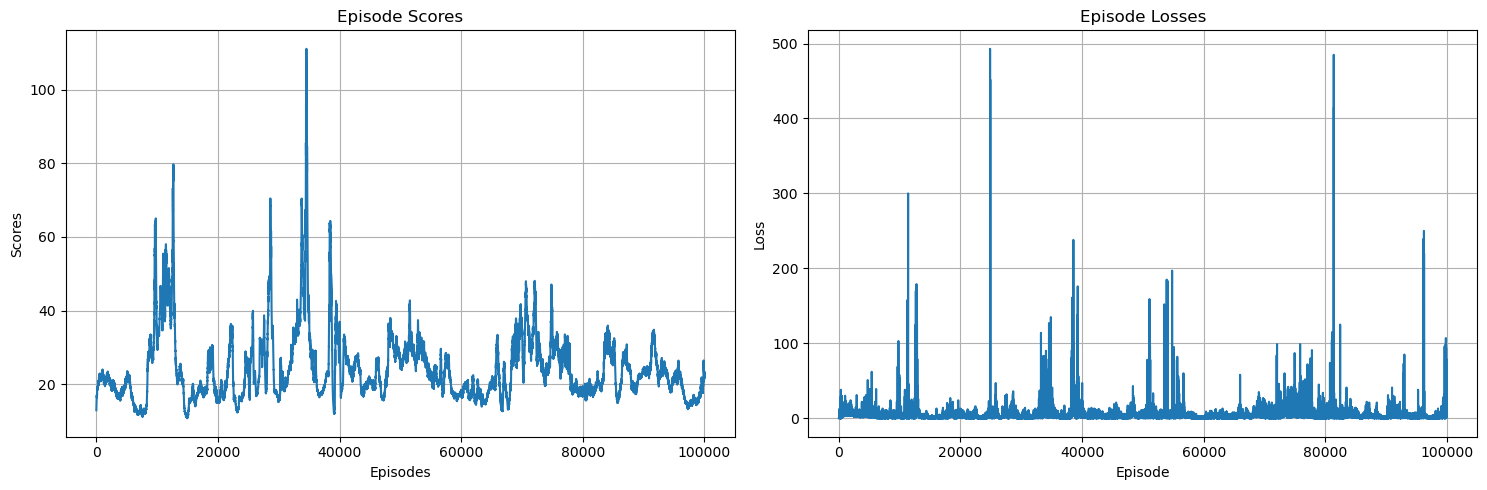

In [8]:
import matplotlib.pyplot as plt
import os
import time

# Create the saved_models folder if it doesn't exist
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Generate a unique train_number based on current timestamp
train_number = time.strftime("%Y%m%d_%H%M%S")
train_folder = f'saved_models/train_{train_number}'

# Create the train_number subfolder inside saved_models
if not os.path.exists(train_folder):
    os.makedirs(train_folder)

# Save the model to the train_number subfolder
torch.save(online_net.state_dict(), f'{train_folder}/online_net.pth')
torch.save(target_net.state_dict(), f'{train_folder}/target_net.pth')

# Save the best model weights to the train_number subfolder
torch.save(best_online_net_weights, f'{train_folder}/best_online_net.pth')
torch.save(best_target_net_weights, f'{train_folder}/best_target_net.pth')

def convert_to_ints(lst):
    return [int(elem.item()) if torch.is_tensor(elem) else int(elem) for elem in lst]

# Plotting the metrics
plt.figure(figsize=(15, 5))

# Plot Rewards
plt.subplot(1, 2, 1)
plt.plot(scores_record)
plt.title('Episode Scores')
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.grid(True)

# Plot Losses (assuming you have a list of losses)
plt.subplot(1, 2, 2)
plt.plot(convert_to_ints(loss_record))
plt.title('Episode Losses')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.grid(True)

# Save the plots to the train_number subfolder
plt.savefig(f'{train_folder}/metrics_plot.png')

plt.tight_layout()
plt.show()
